# **Content-based Course Recommender System using Course Similarities**

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# set a random state
rs = 123

In [3]:
sim_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/sim.csv"
sim_df = pd.read_csv(sim_url)
sim_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.072898,0.039276,0.121113
1,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138270,0.031367,0.076940
2,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.133400,0.012684,0.000000
3,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017443,0.018796,0.158073
4,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.129871,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.033944,0.028239,0.018270,0.094759,0.060474,0.064851,0.053856,0.039467,0.036539,0.060474,...,0.047186,0.116008,0.137406,0.211743,0.256220,1.000000,0.211520,0.168595,0.129766,0.263734
303,0.076825,0.063911,0.082698,0.030638,0.030415,0.000000,0.000000,0.119098,0.055132,0.045622,...,0.177989,0.092381,0.145126,0.527636,0.249675,0.211520,1.000000,0.242269,0.416067,0.178384
304,0.072898,0.138270,0.133400,0.017443,0.129871,0.009285,0.000000,0.254274,0.094165,0.025974,...,0.153128,0.105191,0.138692,0.281108,0.132977,0.168595,0.242269,1.000000,0.220159,0.128902
305,0.039276,0.031367,0.012684,0.018796,0.000000,0.015008,0.024926,0.082199,0.076102,0.055978,...,0.149234,0.093962,0.162170,0.476644,0.222350,0.129766,0.416067,0.220159,1.000000,0.126274


### The similarity matrix is a real number, symmetric metric with each element representing the similarity value (ranged 0 to 1) between course index `i` and course index `j`. 

### We could use `seaborn` to visualize the similarity metric, and since it is symmetric, we can just show the triangular  matrix (lower left):


<AxesSubplot: >

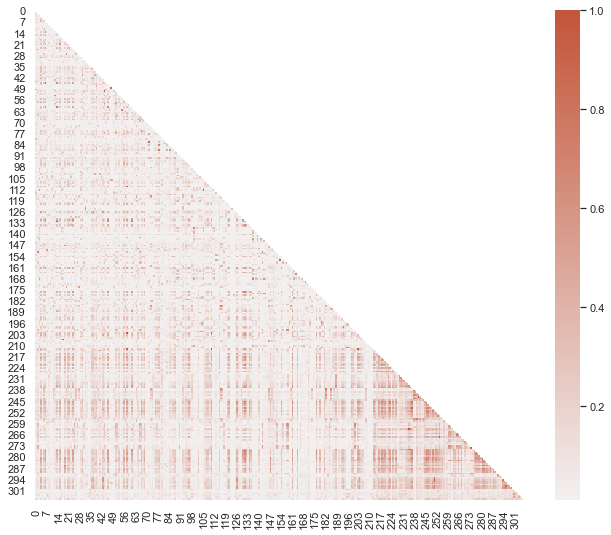

In [4]:
# Configure seaborn
sns.set_theme(style="white")
mask = np.triu(np.ones_like(sim_df, dtype=bool))
_, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Plot a similarity heat map
sns.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)

As we can see from the heatmap; there are many hot spots, which means many courses are similar to each other. Such patterns suggest that it is possible to build a recommender system based on course similarities. 

In [5]:
# Let's first load the course content and BoW dataset
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_df = pd.read_csv(course_url)
bow_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/courses_bows.csv"
bow_df = pd.read_csv(bow_url)

bow_df.head()

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1


#### First, we want to mention that the matrix indices are course indices (such as `0, 1, 2, 3`). Very often we need to query the actual course ids (such as `ML0151EN` and `ML0101ENv3`) based on course indices and vice versa. We can save the course id's and indices into two dictionaries for late queries:

#### Then, based on the `doc_index` and `doc_id` columns, we create an index to id mapping and another id to index mapping in two Python dictionaries:


In [6]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    del grouped_df
    return idx_id_dict, id_idx_dict

In [7]:
get_doc_dicts(bow_df)

({0: 'ML0201EN',
  1: 'ML0122EN',
  2: 'GPXX0ZG0EN',
  3: 'RP0105EN',
  4: 'GPXX0Z2PEN',
  5: 'CNSC02EN',
  6: 'DX0106EN',
  7: 'GPXX0FTCEN',
  8: 'RAVSCTEST1',
  9: 'GPXX06RFEN',
  10: 'GPXX0SDXEN',
  11: 'CC0271EN',
  12: 'WA0103EN',
  13: 'DX0108EN',
  14: 'GPXX0PICEN',
  15: 'DAI101EN',
  16: 'GPXX0W7KEN',
  17: 'GPXX0QR3EN',
  18: 'BD0145EN',
  19: 'HCC105EN',
  20: 'DE0205EN',
  21: 'DS0132EN',
  22: 'OS0101EN',
  23: 'DS0201EN',
  24: 'BENTEST4',
  25: 'CC0210EN',
  26: 'PA0103EN',
  27: 'HCC104EN',
  28: 'GPXX0A1YEN',
  29: 'TMP0105EN',
  30: 'PA0107EN',
  31: 'DB0113EN',
  32: 'PA0109EN',
  33: 'PHPM002EN',
  34: 'GPXX03HFEN',
  35: 'RP0103',
  36: 'RP0103EN',
  37: 'BD0212EN',
  38: 'GPXX0IBEN',
  39: 'SECM03EN',
  40: 'SC0103EN',
  41: 'GPXX0YXHEN',
  42: 'RP0151EN',
  43: 'TA0105',
  44: 'SW0201EN',
  45: 'TMP0106',
  46: 'GPXX0BUBEN',
  47: 'ST0201EN',
  48: 'ST0301EN',
  49: 'SW0101EN',
  50: 'TMP0101EN',
  51: 'DW0101EN',
  52: 'BD0143EN',
  53: 'WA0101EN',
  54: 'GPXX04

In [8]:
#Now suppose we have two example courses:
course1 = course_df[course_df['COURSE_ID'] == "ML0151EN"]
course1

,COURSE_ID,TITLE,DESCRIPTION
200,ML0151EN,machine learning with r,this machine learning with r course dives into...


In [9]:
course2 = course_df[course_df['COURSE_ID'] == "ML0101ENv3"]
course2

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


#### From their titles we can see they are all about machine learning. As such, they should be very similar to each other. Let's try to find their similarity in the similarity matrix.

#### With their course ids, we can use the `id_idx_dict` dictionary to query their row and column index on the similarity matrix:

In [10]:
idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


### Then we can locate their similarity value in row 200 and col 158, `sim_matrix[200][158]`:


In [11]:
sim_matrix = sim_df.to_numpy()
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

It's about 66% meaning these two courses are quite similar to each other.


***
### TASK: Find courses which are similar enough to your enrolled courses.

Now you know how to easily use the pre-computed similarity matrix to query the similarity between any two courses. Do you want to make some course recommendations for yourself?

Let's assume you are an end-user of the online course platform and already audited or completed some courses previously. Next, you expect the system would recommend similar courses based on your enrollments history.

From the full course list, choose any courses that may interest you, such as those machine learning related courses:


In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
course_df[['COURSE_ID', 'TITLE']]

,COURSE_ID,TITLE
0,ML0201EN,robots are coming build iot apps with watson swift and node red
1,ML0122EN,accelerating deep learning with gpu
2,GPXX0ZG0EN,consuming restful services using the reactive jax rs client
3,RP0105EN,analyzing big data in r using apache spark
4,GPXX0Z2PEN,containerizing packaging and running a spring boot application
5,CNSC02EN,cloud native security conference data security
6,DX0106EN,data science bootcamp with r for university proffesors
7,GPXX0FTCEN,learn how to use docker containers for iterative development
8,RAVSCTEST1,scorm test 1
9,GPXX06RFEN,create your first mongodb database


#### _TODO: Browse the course list and choose your interested courses_ 


In [13]:
# akkor most magamnak szűrök, ha van a szövegben python, machine, database, science, analysis
mylist = ['python', 'machine', 'database', 'science', 'analysis']
found = course_df.loc[course_df['DESCRIPTION'].str.contains('python|machine|database|science|analysis', case=False)]

In [14]:
enrolled_course_ids = found.COURSE_ID.unique() # add your interested coures id to the list

In [15]:
enrolled_courses = course_df[course_df['COURSE_ID'].isin(enrolled_course_ids)]
enrolled_courses.head()

,COURSE_ID,TITLE,DESCRIPTION
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with large datasets takes along time in this course you will learn how to use accelerated gpu hardware to overcome the scalability problem in deep learning \nyou can use accelerated hardware such as google s tensor processing unit tpu or nvidia gpu to accelerate your convolutional neural network computations time on the cloud these chips are specifically designed to support the training of neural networks as well as the use of trained networks inference accelerated hardware has recently been proven to significantly reduce training time \nbut the problem is that your data might be sensitiveand you may not feel comfortable uploading it on a public cloud preferring to analyze it on premise in this case you need to use an in house system with gpu support one solution is to use ibm s power systems with nvidia gpu and power ai the power ai platform supports popular machine learning libraries and dependencies including tensorflow caffe torch and theano \nin this course you ll understand what gpu based accelerated hardware is and how it can benefit your deep learning scaling needs you ll also deploy deep learning networks on gpu accelerated hardware for several problems including the classification of images and videos
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing framework used for performing large scale data analysis sparkr provides a distributed data frame api that enables structured data processing with a syntax familiar to r users \n
6,DX0106EN,data science bootcamp with r for university proffesors,a multi day intensive in person data science bootcamp offered by big data university
9,GPXX06RFEN,create your first mongodb database,in this guided project you will get started with mongodb by creating your first database working with collections and doing basic document management
13,DX0108EN,data science bootcamp with python for university professors advance,data science bootcamp with python for university professors advance


Given the full course list, we can find those unselected courses:


In [16]:
all_courses = set(course_df['COURSE_ID'])

unselected_course_ids = all_courses.difference(enrolled_course_ids)

# feel free to uncomment the the below to check unselected_course_ids
#unselected_course_ids

### Now, you can iterate each unselect course and check if it is similar enough to any of your selected courses. If the similarity is larger than a threshold such as 0.5 or 0.6, then add it to your course recommendation list:

_TODO: Complete the following method to recommend courses which are similar to your enrolled courses_


In [17]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    threshold = 0.6 
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                
                # Find the two indices for each enrolled_course and unselect_course, based on their two ids
                idx1 = id_idx_dict[enrolled_course]
                idx2 = id_idx_dict[unselect_course]
                # Calculate the similarity between an enrolled_course and an unselect_course
                # e.g., Course ML0151EN's index is 200 and Course ML0101ENv3's index is 158
                sim = sim_matrix[idx1][idx2]
                # Find the similarity value from the sim_matrix
                # sim = sim_matrix[200][158]
                
                if sim > threshold:
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res

>and according to my choices (chosen courses see above) the following courses are recommended based on the algorithm: 

In [18]:
generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)

{'DA0101EN': 0.7397041774816828,
 'DV0151EN': 0.7235359517703827,
 'excourse74': 0.7177142721392296,
 'BD0101EN': 0.7082138557765277,
 'BD0145EN': 0.7036476305124202,
 'excourse24': 0.6984489505488988,
 'ML0122ENv3': 0.6815739441431503,
 'DB0115EN': 0.6546536707079771,
 'excourse25': 0.648093618628213,
 'excourse82': 0.6315355962274222,
 'ML0115EN': 0.6155678409534919}

***
### TASK: Generate course recommendations based on course similarities for all test users


In the previous task, you made some recommendations for yourself. Next, let's try to make recommendations for all the test users in the test dataset.



In [19]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_users_url)

Let's look at how many test users we have in the dataset.


In [20]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 1000


#### _TODO: Complete the ``generate_recommendations_for_all()`` method to generate recommendations for all users. You may implement the task with different solutions_

In [21]:
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv(test_users_url)
    # Course similarity matrix
    sim_df = pd.read_csv(sim_url)
    # Course content dataframe
    course_df = pd.read_csv(course_url)
    # Course BoW features
    bow_df = pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    # ...
    
    for user_id in test_user_ids:
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        
        #first we query which user enrolled which courses
        enrolled_course_ids = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        # then we remove duplications, simply using set():
        enrolled_course_ids = set(enrolled_course_ids)
        
        # we generate a list called unselected_course_ids:
        all_courses = set(course_df['COURSE_ID']) # step1: we need the unique values from course_df
        unselected_course_ids = all_courses.difference(enrolled_course_ids) #step2: we generate a list called unselected_course_ids
        idx_id_dict, id_idx_dict = get_doc_dicts(bow_df) #step3: we generate the IDs of courses
        sim_matrix = sim_df.to_numpy() #step4: we create a list from sim_df

        # then we call the recommendation function each user, but first
        #we assign it to a variable in order to refer to the return value easier
        a = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)
        # Save the result to courses, sim_scores list
        c = []
        sm = []
        for key, value in a.items():
            c.append(key)
            sm.append(value)
                
        # to make the arrays the same size, the number of times the user must be inserted as many times as len(c) is or len(sm)
        length = len(c)
        
        for i in range(length):
            users.append(user_id)
        for x in c:
            courses.append(x)
        for x in sm:
            sim_scores.append(x)

    
    return users, courses, sim_scores

### After you completed the `generate_recommendations_for_all()` function, you can call it to save the results into a dataframe:


In [22]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
res_df

,USER,COURSE_ID,SCORE
0,37465,DS0110EN,0.732941
1,37465,excourse67,0.708214
2,37465,excourse63,0.694563
3,37465,excourse72,0.652535
4,37465,excourse74,0.650071
5,37465,excourse65,0.638641
6,37465,BD0145EN,0.623544
7,37465,excourse68,0.616759
8,50348,CB0101EN,0.923381
9,50348,DS0110EN,0.732941


***
### Similar to the previous user profile and course genre lab, with the recommendations generated for each user, you need to write some extra analytic code to answer the following questions:

-  On average, how many new/unseen courses have been recommended to each user?
-  What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users?

For example, suppose we have only 3 test users, each user receives the following recommendations:
- User1: ['course1', 'course2']
- User2: ['course3', 'course4']
- User3: ['course3', 'course4', 'course5']

Then, the average recommended courses per user is $(2 + 2 + 3) / 3 = 2.33$. The top-2 recommended courses are: `course3`: 2 times, and `course4`: 2 times.

In [23]:
res_df.shape

(11377, 3)

In [24]:
# On average, how many new courses have been recommended per test user?
# first, let's get a list of users:
userlist = res_df['USER'].unique()

# then go through the res_df for COURSE_ID for each user:
courseids = []
for i in range(len(userlist)):
    l_df = res_df.loc[res_df['USER'] == userlist[i]]
    l = l_df['COURSE_ID'].to_list()
    courseids.append(l)

# let's define the average recommended courses per user:
def avg_rec(users, courses):
    count_courses = sum(len(x) for x in courses)
    count_users = len(users)
    avg_rec_courses = count_courses/count_users
    return avg_rec_courses

print(f'The average recommended courses per user is {avg_rec(userlist, courseids):.0f} in case of a score treshold of 0.6')

The average recommended courses per user is 12 in case of a score treshold of 0.6


In [25]:
# What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all test users.

# Let's first flatten the list of courses (from 2d to 1d)
flat_course_list = [item for sublist in courseids for item in sublist]

import collections

# let's find the 10 most common elements `counter.most_common(10)`:
counter = collections.Counter(flat_course_list)
print('The 10 most common recommended courses are:\n')
print(f"{'COURSE_ID':<15}|{'REC_FREQUENCY':^18}")
print(f"{'_'*15:<15}|{'_'*18:^18}")
for x in counter.most_common(10):
    print(f'{x[0]:<15}|{x[1]:^18}')

The 10 most common recommended courses are:

COURSE_ID      |  REC_FREQUENCY   
_______________|__________________
excourse62     |       579        
excourse22     |       579        
DS0110EN       |       562        
excourse63     |       555        
excourse65     |       555        
excourse72     |       551        
excourse68     |       550        
excourse67     |       539        
excourse74     |       539        
BD0145EN       |       506        
